In [ ]:
"""
Deep autoencoder that aims to reconstruct original MNIST dataset.
Implements dropout and batch normalization.
Implements reducelronplateau and earlystopping callbacks.
Adapted from autoencoder0.
"""

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import drive
import os

# Load mnist dataset and format data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((len(X_train), 28*28)) / 255.0
X_test = X_test.reshape((len(X_test), 28*28)) / 255.0


# Construct layers
input_dim = 28*28
latent_dim = 2
input_vec = Input(shape=(input_dim,))

# encoding layers
el1 = Dense(512) (input_vec)
el2 = Activation('relu') (el1)
el3 = Dense(512) (el2)
el4 = BatchNormalization() (el3)
el5 = Activation('relu') (el4)
el6 = Dropout(0.2) (el5)
el7 = Dense(256) (el6)
el8 = Activation('relu') (el7)
el9 = Dense(256) (el8)
el10 = BatchNormalization() (el9)
el11 = Activation('relu') (el10)
el12 = Dropout(0.2) (el11)
el13 = Dense(128) (el12)
el14 = Activation('relu') (el13)
el15 = Dropout(0.2) (el14)
el16 = Dense(latent_dim) (el15)
el17 = BatchNormalization() (el16)
encoder = Activation('tanh') (el17)

# decoding layers
dl1 = Dense(128) (encoder)
dl2 = BatchNormalization() (dl1)
dl3 = Activation('relu') (dl2)
dl4 = Dropout(0.2) (dl3)
dl5 = Dense(256) (dl4)
dl6 = Activation('relu') (dl5)
dl7 = Dense(256) (dl6)
dl8 = BatchNormalization() (dl7)
dl9 = Activation('relu') (dl8)
dl10 = Dropout(0.2) (dl9)
dl11 = Dense(512) (dl10)
dl12 = Activation('relu') (dl11)
dl13 = Dense(512) (dl12)
dl14 = BatchNormalization() (dl13)
dl15 = Activation('relu') (dl14)
dl16 = Dense(input_dim) (dl15)
decoder = Activation('sigmoid') (dl16)


# Build models
latent_encoder = Model(input_vec, encoder)
autoencoder = Model(input_vec, decoder)

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Train model
print("Training model...\n")
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
hist = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, 
                       callbacks=[reduce_lr, early_stopping], 
                       validation_data=(X_test, X_test))
print("\nDone training.")


# Save models
# drive.mount('/content/drive') # only if drive is not yet mounted
root = './drive/MyDrive/Colab Notebooks/autoencoder1'
latent_encoder.save(os.path.join(root, 'models/latent_encoder.h5'))
autoencoder.save(os.path.join(root, 'models/autoencoder.h5'))

11501568/11490434 [==============================] - 0s 0us/step
Training model...

Epoch 1/100
234/235 [============================>.] - ETA: 0s - loss: 0.2269

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0   

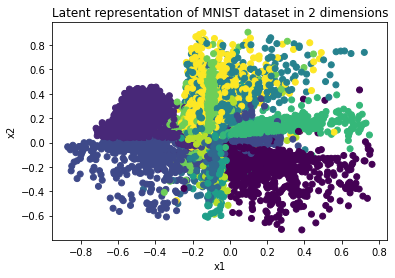

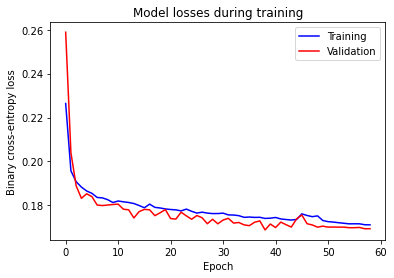

In [ ]:
""" Results analysis """

from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load models
root = './drive/MyDrive/Colab Notebooks/autoencoder1'
latent_encoder = load_model(os.path.join(root, 'models/latent_encoder.h5'))
autoencoder = load_model(os.path.join(root, 'models/autoencoder.h5'))

# Model summary
autoencoder.summary()


# Obtain latent representation (784 dimensions --> 2)
latent_repr = latent_encoder.predict(X_test)
plt.scatter(latent_repr[:,0], latent_repr[:,1], c=y_test)
plt.title("Latent representation of MNIST dataset in 2 dimensions")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


# Plot loss against epoch
# Model loss converges as expected
plt.plot(hist.history['loss'], color='#0000ff')
plt.plot(hist.history['val_loss'], color='#ff0000')
plt.title("Model losses during training")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.legend(['Training', 'Validation'])
plt.show()


# Use autoencoder model to predict input images
n = 10 # number of output images -- range (0, len(X_test))
predictions = autoencoder.predict(X_test)[:n]

# Reconstruct 28*28 image array with pixel values in range (0, 255)
predictions = predictions.reshape((len(predictions), 28, 28))
predictions = (predictions * 255).astype('uint8') 

# Save images in /predictions and /raw folders
# Images are saved as index(label).png
# eg. 001(7).png --> image 1 has target label 7
for idx, pred_array in enumerate(predictions):
    # Save predicted images
    pred_img = Image.fromarray(pred_array)
    pred_img.save(os.path.join(root, 'predictions', f'{idx:03}({y_test[idx]}).png'))
    
    # Save raw images
    raw_array = X_test[idx].reshape((28, 28))
    raw_array = (raw_array * 255).astype('uint8')
    raw_img = Image.fromarray(raw_array)
    raw_img.save(os.path.join(root, 'raw', f'{idx:03}({y_test[idx]}).png'))
